# GP-select Demo on Gaussian Mixture Model

### corresponding to paper:GP-select: Accelerating EM using adaptive subspace preselection
### Zhenwen Dai
### 24//11/2016

In [1]:
import numpy as np
import GPy
from pylab import *
%matplotlib inline

## GMM implementation with GP-select

We demonstrate an EM implementation of Gaussian Mixture Model with GP-select. The GMM illustrates visually and intuitively how GP-select works. 
The Gaussian Process selection function is implemented based on [GPy](https://github.com/SheffieldML/GPy) with a general standard choice of kernel, noted below. Additionally, one could explicitly visualize the effect of different selection functions.


In [2]:
class GMM(object):
    def __init__(self,data, nClusters, gp_select=False, C_select=None):
        self.data = data
        self.nClusters = nClusters
        self.gp_select = gp_select
        self.C_select = C_select
        self.selector = None
        self._init_clusters(data)
        if self.gp_select:
            self._init_gp_select()
        
    # ====== GP-select ========
        
    def _init_gp_select(self):
        if self.selector is None:
            ds = np.square(self.data[:,None,:] - self.mu[None,:,:]).sum(2)
            idx = np.argsort(ds,axis=1)[:,:self.C_select]
            q_m = self._E_step_select(idx)[0]
            self.idx = idx
            self.q = q_m
            
            d = self.data.shape[1]
            self.selector = GPy.models.GPRegression(self.data,q_m,
                                # standard kernel choice: combination of linear and nonlinear kernels with a bias term
                                kernel=GPy.kern.RBF(d,ARD=False)+GPy.kern.Linear(d)+GPy.kern.Bias(d)) 
            self.selector.optimize()
    
    def _update_gp_select(self,q_m):
        if self.selector is None:
            self._init_gp_select()
        else:
            self.selector.set_XY(Y=q_m)
            self.selector.optimize()
    
    def _select(self):
        q = self.selector.predict(self.selector.X)[0]
        idx = np.argsort(q,axis=1)[:,-self.C_select:]
        return idx
    
    def _eval_Gaussians_select(self, Y, idx):
        from GPy.util.linalg import jitchol, dtrtrs
        const_p = np.log(2.*np.pi)*self.mu.shape[1]/-2.
        
        logp = np.zeros((Y.shape[0],idx.shape[1]))
        logp_all = np.zeros((Y.shape[0],self.nClusters))
        Ls = []
        log_pi = []
        for i_C in range(self.nClusters):
            Ls.append( jitchol(self.sigma[i_C]) )
            log_pi.append(np.log(self.pi[i_C]))
            
        b_idx = np.zeros((Y.shape[0],self.nClusters),dtype=np.int)
        for n in range(Y.shape[0]):
            b_idx[n,idx[n]] = 1
            
        
        for i_C in range(self.nClusters):
            L = Ls[i_C]
            m = self.mu[i_C]
            n_idx = np.where(b_idx[:,i_C]==1)[0]
            tmp = dtrtrs(L,(Y[n_idx]-m).T)[0].T
            logL = const_p-np.log(np.diag(L)).sum() + np.square(tmp).sum(axis=1)/-2.
            logp_all[n_idx,i_C] = logL + log_pi[i_C]
        
        for n in range(Y.shape[0]):
            logp[n] = logp_all[n,idx[n]]

        return logp
    
    def _E_step_select(self,idx):
        logp = self._eval_Gaussians_select(self.data,idx)
        self.logp = logp

        logp_max = np.max(logp,axis=1)
        q = np.exp(logp - logp_max[:,None])
        q_sum = q.sum(axis=1)
        logL = np.log(q_sum).sum()+logp_max.sum()
        q = q/q_sum[:,None]
        
        q_all = np.zeros((self.data.shape[0],self.nClusters))
        for n in range(self.data.shape[0]):
            q_all[n,idx[n]] = q[n]
        
        return q_all, logL
        
    # ====== GP-select ========
        
    def _init_clusters(self,data):
        self.pi = np.ones(self.nClusters)/self.nClusters
        self.mu = data[np.random.permutation(data.shape[0])[:self.nClusters]]
        self.sigma = np.zeros((self.nClusters,data.shape[1],data.shape[1]))
        self.sigma[:] = np.identity(data.shape[1])[None,:,:]*1.
        
    def _eval_Gaussians(self, Y):
        from GPy.util.linalg import jitchol, dtrtrs
        const_p = np.log(2.*np.pi)*self.mu.shape[1]/-2.
        
        logp = np.zeros((Y.shape[0],self.nClusters))
        for i_C in range(self.nClusters):
            L = jitchol(self.sigma[i_C])
            m = self.mu[i_C]
            tmp = dtrtrs(L,(Y-m).T)[0].T
            logL = const_p-np.log(np.diag(L)).sum() + np.square(tmp).sum(axis=1)/-2.
            logp[:,i_C] = logL
        return logp

    def _E_step(self):
        logp = self._eval_Gaussians(self.data)
        logp += np.log(self.pi)
                
        logp_max = np.max(logp,axis=1)
        q = np.exp(logp - logp_max[:,None])
        q_sum = q.sum(axis=1)
        logL = np.log(q_sum).sum()+logp_max.sum()
        q = q/q_sum[:,None]
        
        return q, logL
    
    def _M_step(self, q):
        
        q_sum = q.sum(axis=0)
        q_norm = q/q_sum
        self.pi = q_sum/self.data.shape[0]
        self.mu = q_norm.T.dot(self.data)
        d = self.data[:,None,:] - self.mu[None,:,:]
        self.sigma = (q_norm[:,:,None,None]*d[:,:,None,:]*d[:,:,:,None]).sum(0)#+np.identity(self.sigma.shape[2])[None,:,:]*1e-20
        
    def optimize(self,n_iter):
        Ls = []
        for i in range(n_iter):
            if self.gp_select:
                idx = self._select()
                self.idx = idx
                q, logL = self._E_step_select(idx)
            else:
                q, logL = self._E_step()
            self.q = q
            Ls.append(logL)
#            print i, logL
            self._M_step(q)
            
            if self.gp_select:
                self._update_gp_select(q)
        return Ls
            
    def plot_2D(self, ax=None):
        assert self.data.shape[1]==2
        if ax==None:
            fig = figure()
            ax = fig.gca()
            
        ax.plot(self.data[:,0],self.data[:,1],'.',alpha=0.3)
        from matplotlib.patches import Ellipse        
        for i in range(self.nClusters):
            w,v = np.linalg.eig(self.sigma[i])
            e = Ellipse(self.mu[i], width=np.sqrt(w[0])*1.96*2., height=np.sqrt(w[1])*1.96*2., angle=np.arccos(v[0,0])/np.pi*180)
            e.set_clip_box(ax.bbox)
            e.set_facecolor('none')
            e.set_edgecolor('k')
            ax.add_artist(e)
#        show()

## A Simple Demo on Synthetic Data

### Synthetic Data Generation  

A synthetic dataset with 500 data points (5 clusters) on 2D space is generated. The dataset is ploted in the following figure with each color indicating a cluster.

In [3]:
np.random.seed(11)
nClusters = 5
nData = 100

data = []
label = []

for i in range(nClusters):
    mean = np.random.rand(2)
    v = np.random.rand(2)*0.01
    theta = np.random.rand()*np.pi
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    cov = R.dot(np.diag(v)).dot(R.T)
    d = np.random.multivariate_normal(mean=mean,cov=cov,size=(nData,))
    data.append(d)
    label.append(np.ones(nClusters)*nData)
    
data = np.vstack(data)
label = np.hstack(label)


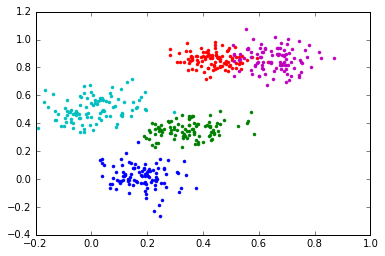

In [4]:
for i in range (10):
    plot(data[i*nData:(i+1)*nData,0],data[i*nData:(i+1)*nData,1],'.')

### Clustering with GMM and GMM with GP-select

In [5]:
gmm_select = GMM(data,5,gp_select=True,C_select=3)
L_gmm_select = gmm_select.optimize(50)

In [6]:
gmm = GMM(data,5,gp_select=False)
L_gmm = gmm.optimize(50)

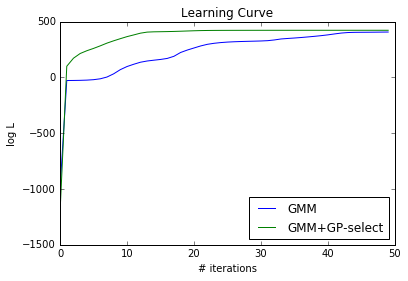

In [7]:
fig = figure()
ax = fig.gca()
ax.plot(L_gmm,label='GMM')
ax.plot(L_gmm_select,label='GMM+GP-select')
ax.legend(loc='lower right')
ax.set_title('Learning Curve')
ax.set_xlabel('# iterations')
ax.set_ylabel('log L')

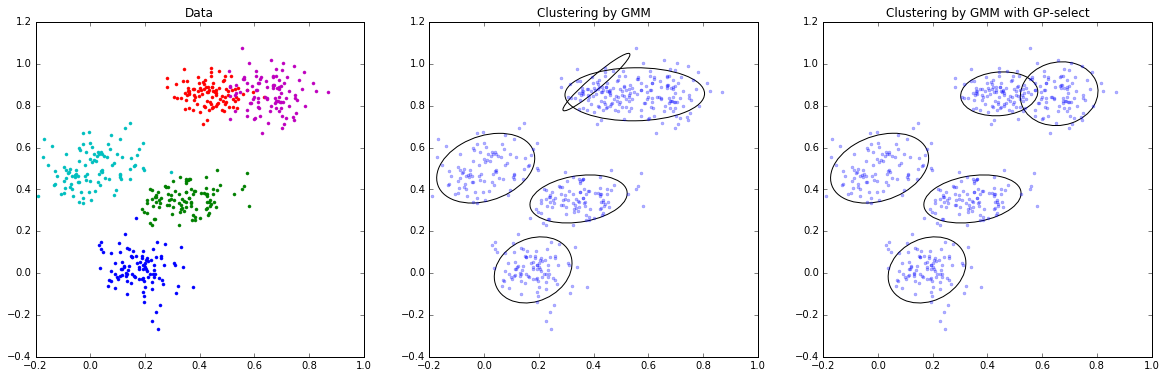

In [8]:
fig,axs = subplots(1,3,figsize=(20,6))
for i in range (10):
    axs[0].plot(data[i*nData:(i+1)*nData,0],data[i*nData:(i+1)*nData,1],'.')
axs[0].set_title('Data')
gmm.plot_2D(ax=axs[1])
axs[1].set_title('Clustering by GMM')
gmm_select.plot_2D(ax=axs[2])
axs[2].set_title('Clustering by GMM with GP-select (non-linear kernel)')
show()